# Data Science Bowl 2017
https://www.kaggle.com/c/data-science-bowl-2017

Sentdex's Reading Files - 3D Convolutional Neural Network w/ Kaggle and 3D medical imaging p.2
https://www.youtube.com/watch?v=KlffppN47lc

In [1]:
import pydicom
#import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc

%matplotlib inline

In [2]:
# Select path where patients and their subsequent CT scans are
data_dir = 'C:/Users/moogl/Desktop/UChicago/Capstone Project/2. Implementation/Lung CT Data/SPIE-AAPM Lung CT Challenge/'
patients = os.listdir(data_dir + '1. Original Dataset/')

In [3]:
#patients

In [4]:
labels_df = pd.read_csv(data_dir + 'Dataset Info/Calib and test set labels.csv')
labels_df.set_index('Patient ID', inplace=True)
labels_df.sort_index(inplace=True)
labels_df.head()

,Diagnosis,x,y,Instance Number
Patient ID,,,,
CT-Training-BE001,benign,405,296,169
CT-Training-BE002,benign,184,268,117
CT-Training-BE006,benign,449,266,241
CT-Training-BE007,benign,385,206,194
CT-Training-BE010,benign,120,336,69


intercept: -1024 , slope: 1
<class 'numpy.ndarray'>


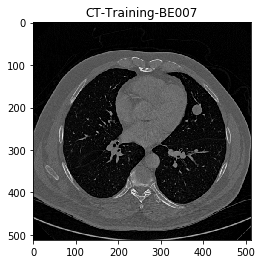

In [10]:
#Auto cropping nodules
for patient in patients[3:4]:
    label = labels_df.get_value(patient, 'Diagnosis')
    path = data_dir + '1. Original Dataset/' + patient
    
    # from https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    
    #slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))    # x are individual dicom files
    slices.sort(key = lambda x: float(x.InstanceNumber))    # x are individual dicom files, sort by instance number
    
    single_slice = slices[194 - 1].pixel_array.astype(np.int16)

    intercept = slices[194 - 1].RescaleIntercept
    slope = slices[194 - 1].RescaleSlope
    
    single_slice = (single_slice * slope + intercept).astype(np.int16)
    
    print("intercept:", intercept, ",", "slope:", slope)
    print(type(single_slice))
    
    plt.imshow(single_slice, cmap='gray')
    plt.title(patient)
    plt.show()

In [5]:
slices[69].InstanceNumber

'70'

In [6]:
slices[70 - 1].pixel_array.shape

(512, 512)

# Auto crop nodules
- take input from Calib and test set labels.csv (patient ID, label, X,Y, and instance number)
- take into account that there are can be two identical patients (each indicating a different nodule in a patient CT scan)
- If a single patient had 2 nodules, deleted the second one on Calib and test set labels***** fix later
- LUNGx-CT004, LUNGx-CT005, LUNGx-CT016, LUNGx-CT017, LUNGx-CT043, LUNGx-CT047, LUNGx-CT054, LUNGx-CT056, LUNGx-CT059

In [7]:
# Select path where patients and their subsequent CT scans are
data_dir = 'C:/Users/moogl/Desktop/UChicago/Capstone Project/2. Implementation/Lung CT Data/SPIE-AAPM Lung CT Challenge/'

# csv to pandas dataframe
coordinates_df = pd.read_csv(data_dir + 'Dataset Info/' + 'Calib and test set labels (with 2 nodule patients).csv')
coordinates_df.sort_values(by=['Patient ID'], inplace=True)
#coordinates_df.reset_index(drop=True, inplace=True)   # enable if not using 4 and 5
coordinates_df.set_index('Patient ID', drop=True, inplace=True)
coordinates_df.reset_index(inplace=True)               # disable if not using 3

patients = list(coordinates_df['Patient ID'])

coordinates_df.head(11)

,Patient ID,Diagnosis,x,y,Instance Number
0,CT-Training-BE001,benign,405,296,169
1,CT-Training-BE002,benign,184,268,117
2,CT-Training-BE006,benign,449,266,241
3,CT-Training-BE007,benign,385,206,194
4,CT-Training-BE010,benign,120,336,69
5,CT-Training-LC001,malignant,120,325,135
6,CT-Training-LC002,malignant,139,359,70
7,CT-Training-LC003,malignant,375,323,70
8,CT-Training-LC008,malignant,95,328,65
9,CT-Training-LC009,malignant,145,299,63


In [8]:
patients[:5]

['CT-Training-BE001',
 'CT-Training-BE002',
 'CT-Training-BE006',
 'CT-Training-BE007',
 'CT-Training-BE010']

In [11]:
# Save 64x64 cropped out lung nodules from axial slices, saved in: "3. Slice Crop"
#i = 0
#for index, patient in enumerate(patients):
for index, patient in enumerate(patients):

    #label = labels_df.get_value(patient, 'Diagnosis')
    path = data_dir + '1. Original Dataset/' + patient
    
    # from https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial
    # places all dicom files of a single patient into a list called slices for which you can call DICOM attributes on
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.InstanceNumber))    # x are individual dicom files, sort by instance number
    
    # Convert to HU units using CT data
    instance_number = coordinates_df.iloc[index]['Instance Number']     # replace index with i and uncomment out i=0 and i+=1 if fail
    print('Patient:', patient, ',\tInstance number:', instance_number)
    single_slice = slices[instance_number - 1].pixel_array
    
    # HU = pixel_value * slope + intercept
    intercept = slices[instance_number - 1].RescaleIntercept
    slope = slices[instance_number - 1].RescaleSlope
    single_slice = (single_slice * slope + intercept).astype(np.int16)
    
    # slice_df is the dataframe containing the single axial slice containing the nodule
    slice_df = pd.DataFrame(single_slice, dtype='int16')
    
    print(slice_df)
    
    # Auto-cropping begins (if want to use 3D crop, take 64 slices centered around the instance number)
    centerX = coordinates_df.iloc[index]['x']
    centerY = coordinates_df.iloc[index]['y']
    img_crop = single_slice[centerY-32:centerY+32, centerX-32:centerX+32]
    
    # takes into account same patient names in the patients list (represents 2 nodules for the same patient)   
    # If the previous patient in the list was the same name, look for '_2_cropped.tiff'
    if patient == patients[index-1]:
        misc.imsave(data_dir + '3. Slice Crop/' + patient + '_2_cropped.tiff', img_crop)
    else:
        misc.imsave(data_dir + '3. Slice Crop/' + patient + '_cropped.tiff', img_crop)
    
    # Save 512x512 axial slice containing the nodule to folder: "2. Single Slice" (axial)
    #if patient == patients[index-1]:
    #    misc.imsave(data_dir + '2. Single Slice/' + patient + '_2_cropped.tiff', slices[instance_number - 1].pixel_array)
    #else:
    #    misc.imsave(data_dir + '2. Single Slice/' + patient + '_cropped.tiff', slices[instance_number - 1].pixel_array)
    
    #i += 1

print('All done!')

Patient: CT-Training-BE001 ,	Instance number: 169
      0     1     2     3     4     5     6     7     8     9    ...    502  \
0    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
1    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
2    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
3    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
4    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
5    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
6    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
7    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
8    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
9    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
10   1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
11

Patient: CT-Training-BE002 ,	Instance number: 117
      0     1     2     3     4     5     6     7     8     9    ...    502  \
0    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
1    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
2    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
3    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
4    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
5    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
6    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
7    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
8    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
9    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
10   1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
11

Patient: CT-Training-BE006 ,	Instance number: 241
      0      1      2      3      4      5      6      7      8      9    \
0    1000   1000   1000   1000   1000   1000   1000   1000   1000   1000   
1    1000   1000   1000   1000   1000   1000   1000   1000   1000   1000   
2    1000   1000   1000   1000   1000   1000   1000   1000   1000   1000   
3    1000   1000   1000   1000   1000   1000   1000   1000   1000   1000   
4    1000   1000   1000   1000   1000   1000   1000   1000   1000   1000   
5    1000   1000   1000   1000   1000   1000   1000   1000   1000   1000   
6    1000   1000   1000   1000   1000   1000   1000   1000   1000   1000   
7    1000   1000   1000   1000   1000   1000   1000   1000   1000   1000   
8    1000   1000   1000   1000   1000   1000   1000   1000   1000   1000   
9    1000   1000   1000   1000   1000   1000   1000   1000   1000   1000   
10   1000   1000   1000   1000   1000   1000   1000   1000   1000   1000   
11   1000   1000   1000   1000   1000 

Patient: CT-Training-BE007 ,	Instance number: 194
      0     1     2     3     4     5     6     7     8     9    ...    502  \
0    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
1    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
2    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
3    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
4    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
5    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
6    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
7    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
8    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
9    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
10   1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
11

Patient: CT-Training-BE010 ,	Instance number: 69
      0     1     2     3     4     5     6     7     8     9    ...    502  \
0    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
1    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
2    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
3    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
4    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
5    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
6    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
7    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
8    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
9    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
10   1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
11 

Patient: CT-Training-LC001 ,	Instance number: 135
      0     1     2     3     4     5     6     7     8     9    ...    502  \
0    1260  1025  1105  1180  1145  1290  1225  1085  1140  1005  ...   1285   
1    1230  1185  1190  1170  1095  1150  1385  1090  1200  1060  ...   1260   
2    1230  1195  1000  1065  1205  1110  1210  1060  1295  1200  ...   1150   
3    1285  1295  1000  1070  1260  1225  1290  1060  1210  1155  ...   1385   
4    1215  1380  1135  1105  1095  1000  1230  1265  1090  1260  ...   1170   
5    1130  1415  1240  1160  1170  1110  1120  1235  1020  1060  ...   1185   
6    1035  1270  1250  1210  1120  1200  1325  1130  1030  1030  ...   1415   
7    1040  1195  1125  1190  1280  1055  1215  1195  1065  1100  ...   1340   
8    1135  1265  1000  1000  1320  1175  1185  1280  1040  1140  ...   1025   
9    1145  1290  1190  1000  1100  1095  1175  1380  1155  1020  ...   1150   
10   1185  1135  1220  1175  1025  1040  1090  1285  1310  1000  ...   1205   
11

Patient: CT-Training-LC002 ,	Instance number: 70
      0     1     2     3     4     5     6     7     8     9    ...    502  \
0    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1180   
1    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1375   
2    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1435   
3    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1175   
4    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
5    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
6    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1110   
7    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1145   
8    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1135   
9    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1235   
10   1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1180   
11 

Patient: CT-Training-LC003 ,	Instance number: 70
      0     1     2     3     4     5     6     7     8     9    ...    502  \
0    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
1    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
2    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
3    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
4    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
5    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
6    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
7    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
8    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
9    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
10   1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1000   
11 

Patient: CT-Training-LC008 ,	Instance number: 65
      0     1     2     3     4     5     6     7     8     9    ...    502  \
0    1110  1110  1195  1055  1125  1090  1085  1125  1160  1210  ...   1135   
1    1140  1045  1270  1085  1170  1170  1100  1050  1105  1395  ...   1220   
2    1090  1010  1160  1105  1240  1230  1075  1060  1070  1255  ...   1125   
3    1145  1130  1115  1065  1170  1200  1090  1165  1105  1210  ...   1010   
4    1195  1255  1200  1155  1185  1160  1025  1035  1055  1000  ...   1115   
5    1130  1200  1295  1250  1310  1165  1000  1000  1175  1195  ...   1175   
6    1080  1000  1180  1085  1250  1175  1080  1000  1115  1125  ...   1130   
7    1105  1045  1245  1130  1265  1025  1000  1170  1290  1005  ...   1315   
8    1100  1130  1225  1030  1185  1170  1000  1090  1375  1225  ...   1275   
9    1110  1160  1315  1000  1000  1285  1200  1135  1110  1055  ...   1040   
10   1150  1175  1210  1055  1070  1270  1105  1175  1165  1000  ...   1190   
11 

Patient: CT-Training-LC009 ,	Instance number: 63
      0     1     2     3     4     5     6     7     8     9    ...    502  \
0    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1165   
1    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1225   
2    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1110   
3    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1205   
4    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1045   
5    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1155   
6    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1200   
7    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1060   
8    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1205   
9    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1030   
10   1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...   1265   
11 

KeyboardInterrupt: 

In [ ]:
elements = ('foo', 'bar', 'bar')

for count, elem in enumerate(elements):
    if elem == elements[count-1]:
        print(count, elem)